## Overview

Created by Marina Dunn, Spring 2022

**Resources used:**

https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2

https://github.com/deepskies/deepmerge-public/blob/master/DeepMerge-noisy.ipynb

https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e

https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-softmax-crossentropy

https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/08/26/01-Bayesian-Convolutional-Neural-Network.html#Analyse-the-model-predictions

https://towardsdatascience.com/ultimate-guide-to-input-shape-and-model-complexity-in-neural-networks-ae665c728f4b

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739

https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673

https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99

### Goal: 
Build, compile, and train Convolutional Neural Network (CNN), and eventually Bayesian Neural Network (BNN), on simulated data from LSST to classify whether a galaxy is a spiral, elliptical, or has undergone a merger. 

Steps:

1. Load data; define training, test, and validation sets, and explore data
2. Build a deterministic CNN in Tensorflow & Keras
3. Compile the CNN
4. Train the CNN to perform a classification task
5. Evaluate the results and visualize
6. Visualize feature maps for best model
7. Perform Transfer Learning with additional data
8. Build a probabilistic CNN in Tensorflow & Keras
9. Compile the CNN
10. Train the CNN to perform a classification task
11. Evaluate the results and visualize
12. Build a BNN in Tensorflow & Keras
13. Compile the BNN
14. Train the BNN to perform a classification task
15. Evaluate the results and visualize

### Imports:
`numpy`: arrays

`matplotlib` and `seaborn`: plotting data

`keras` and `tensorflow`: building and training CNN

`sklearn`: evaluating CNN and hyperparameter optimization

## Load Data

In [124]:
import os
import codecs
import sys
import json
import numpy as np
from numpy import random
from scipy import interp
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import __future__
import time
from pprint import pprint
from pathlib import Path
from datetime import datetime
import itertools
import warnings
warnings.filterwarnings("ignore")

# machine learning
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model, model_from_json, load_model
from tensorflow.keras.layers import BatchNormalization, Input, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, History, ModelCheckpoint, EarlyStopping, BackupAndRestore, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#import tensorflow_hub as hub
from tensorflow.keras.utils import normalize
from tensorflow.keras import models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import sklearn
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, brier_score_loss, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
# hyperparameter optimization
#from sklearn.model_selection import GridSearchCV

# plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
import seaborn as sns
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
import matplotlib
%matplotlib inline

In [64]:
print("Scikit-learn Version: ", sklearn.__version__)
print("Torch Version: ", torch.__version__)
print("Matplotlib Version: ", matplotlib.__version__)
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Scikit-learn Version:  1.0.2
Torch Version:  1.12.0
Matplotlib Version:  3.5.1
Tensorflow Version:  2.9.0
Tensorflow Probability Version:  0.16.0


In [50]:
%%time
# Load year 1 train, test, validation image files (noisy)
# Normalize the data
X_train_1 = np.load('images_Y1_train.npy')
X_train_1 = normalize(X_train_1)

X_test_1 = np.load('images_Y1_test.npy')
X_test_1 = normalize(X_test_1)

X_valid_1 = np.load('images_Y1_valid.npy')
X_valid_1 = normalize(X_valid_1)

# Load year 10 train, test, validation image files (pristine)
X_train_10 = np.load('images_Y10_train.npy')
X_train_10 = normalize(X_train_10)

X_test_10 = np.load('images_Y10_test.npy')
X_test_10 = normalize(X_test_10)

X_valid_10 = np.load('images_Y10_valid.npy')
X_valid_10 = normalize(X_valid_10)

CPU times: user 2.37 s, sys: 12.4 s, total: 14.7 s
Wall time: 23.2 s


In [51]:
%%time
# Load image label files
Y_train = np.load('labels_train.npy')
Y_test = np.load('labels_test.npy')
Y_valid = np.load('labels_valid.npy')

CPU times: user 960 µs, sys: 1.7 ms, total: 2.66 ms
Wall time: 2.91 ms


In [52]:
%%time
# Load small subset files
X_test_1_sub = np.load('images_Y1_test_150.npy')
X_test_1_sub = normalize(X_test_1_sub)

X_test_10_sub = np.load('images_Y10_test_150.npy')
X_test_10_sub = normalize(X_test_10_sub)

Y_test_sub = np.load('labels_test_150.npy')

CPU times: user 12.7 ms, sys: 32.1 ms, total: 44.8 ms
Wall time: 49.7 ms


In [53]:
%%time
# shuffle year 1 data
X_train_1 = shuffle(X_train_1)
X_test_1 = shuffle(X_test_1)
X_valid_1 = shuffle(X_valid_1)
X_test_1_sub = shuffle(X_test_1_sub)

# shuffle year 10 data
X_train_10 = shuffle(X_train_10)
X_test_10 = shuffle(X_test_10)
X_valid_10 = shuffle(X_valid_10)
X_test_10_sub = shuffle(X_test_10_sub)

CPU times: user 739 ms, sys: 10.7 s, total: 11.5 s
Wall time: 51.6 s


In [54]:
%%time
# shuffle labels
Y_train = shuffle(Y_train)
Y_test = shuffle(Y_test)
Y_valid = shuffle(Y_valid)
Y_test_sub = shuffle(Y_test_sub)

CPU times: user 1.13 ms, sys: 1.23 ms, total: 2.36 ms
Wall time: 5.17 ms


In [55]:
%%time
# cast data types
X_train_1 = X_train_1.astype('float32')
X_test_1 = X_test_1.astype('float32')
X_valid_1 = X_valid_1.astype('float32')
X_test_1_sub = X_test_1_sub.astype('float32')

X_train_10 = X_train_10.astype('float32')
X_test_10 = X_test_10.astype('float32')
X_valid_10 = X_valid_10.astype('float32')
X_test_10_sub = X_test_10_sub.astype('float32')

Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')
Y_valid = Y_valid.astype('float32')
Y_test_sub = Y_test_sub.astype('float32')

CPU times: user 660 ms, sys: 7.88 s, total: 8.54 s
Wall time: 29.8 s


In [56]:
# initial training variables
NUM_TRAIN = 23487
NUM_TEST = 6715
NUM_VALIDATION = 3355
shuffle = True

In [57]:
# check data sizes
NUM_TOTAL = NUM_TRAIN + NUM_TEST + NUM_VALIDATION
print(NUM_TOTAL)
assert NUM_TOTAL == len(X_train_1) + len(X_test_1) + len(X_valid_1), "total training, test, validation samples not equal to total samples - exiting"

33557


## Exploratory Data Analysis

In [65]:
Y_train_df = pd.DataFrame(Y_train)
Y_test_df = pd.DataFrame(Y_test)
Y_valid_df = pd.DataFrame(Y_valid)

In [66]:
# Labels are one-hot encoded
Y_valid_df.head()

,0,1,2
0,0.00,1.00,0.00
1,0.00,1.00,0.00
2,1.00,0.00,0.00
3,1.00,0.00,0.00
4,0.00,0.00,1.00


In [67]:
Y_train_df.info()
# Y_test_df.info()
# Y_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23487 entries, 0 to 23486
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       23487 non-null  float32
 1   1       23487 non-null  float32
 2   2       23487 non-null  float32
dtypes: float32(3)
memory usage: 275.4 KB


In [68]:
Y_train_df.sum()

0   10,017.00
1    5,705.00
2    7,765.00
dtype: float32

In [69]:
Y_test_df.sum()

0   2,863.00
1   1,631.00
2   2,221.00
dtype: float32

In [70]:
Y_valid_df.sum()

0   1,432.00
1     815.00
2   1,108.00
dtype: float32

In [71]:
Y_train_df.describe()
# Y_test_df.describe()
# Y_valid_df.describe()

,0,1,2
count,"23,487.00","23,487.00","23,487.00"
mean,0.43,0.24,0.33
std,0.49,0.43,0.47
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,1.00,0.00,1.00
max,1.00,1.00,1.00


In [91]:
print( "Data dimensions: ")
# same for years 10 and 1
print( "Y1 Training Set:", np.shape(X_train_1), "Labels:", np.shape(Y_train)) 
print( "Y1 Test Set:", np.shape(X_test_1), "Labels:", np.shape(Y_test))
print( "Y1 Validation Set:", np.shape(X_valid_1), "Labels:", np.shape(Y_valid), '\n')

print( "Y10 Training Set:", np.shape(X_train_10), "Labels:", np.shape(Y_train)) # same for year 10
print( "Y10 Test Set:", np.shape(X_test_10), "Labels:", np.shape(Y_test)) # same for year 10
print( "Y10 Validation Set:", np.shape(X_valid_10), "Labels:", np.shape(Y_valid)) # same for year 10

Data dimensions: 
Y1 Training Set: (23487, 3, 100, 100) Labels: (23487, 3)
Y1 Test Set: (6715, 3, 100, 100) Labels: (6715, 3)
Y1 Validation Set: (3355, 3, 100, 100) Labels: (3355, 3) 

Y10 Training Set: (23487, 3, 100, 100) Labels: (23487, 3)
Y10 Test Set: (6715, 3, 100, 100) Labels: (6715, 3)
Y10 Validation Set: (3355, 3, 100, 100) Labels: (3355, 3)


In [92]:
print("Y1 Subset Test Set: ", np.shape(X_test_1_sub), "Labels:", np.shape(Y_test_sub))
print("Y10 Subset Test Set: ", np.shape(X_test_10_sub), "Labels:", np.shape(Y_test_sub)) 

Y1 Subset Test Set:  (150, 3, 100, 100) Labels: (150, 3)
Y10 Subset Test Set:  (150, 3, 100, 100) Labels: (150, 3)


### Summary Of Dataset Attributes

Each image represents a series of pixels in a grid-like format with a value of brightness for each pixel.

```
Multi-Class Classification
3 columns: spiral (or '0'), elliptical ('1'), or a galaxy merger ('2’) - (num_classes – 1)
No null values, min:0, max:1

Training set details:
• 23487 total images
• 10017 Spiral galaxies (mean: 0.426491, std: 0.494577)
• 5705 Elliptical galaxies (mean: 0.242900, std: 0.428844)
• 7765 Merger galaxies (mean: 0.330608, std: 0.470442)
• Memory usage: 550.6 KB

Test set details:
• 6715 total images
• 2863 Spiral galaxies (mean: 0.426359, std: 0.494584)
• 1631 Elliptical galaxies (mean: 0.242889, std: 0.428861)
• 2221 Merger galaxies (mean: 0.330752, std: 0.470519)
• Memory usage: 157.5 KB

Validation set details:
• 3355 total images
• 1432 Spiral galaxies (mean: 0.426826, std: 0.494690)
• 815 Elliptical galaxies (mean: 0.242921, std: 0.428912)
• 1108 Merger galaxies (mean: 0.330253, std: 0.470374)
• Memory usage: 78.8 KB
```

In [58]:
class_names = ['Spiral', 'Elliptical', 'Merger']
NUM_CLASSES = len(class_names)
print(class_names)

['Spiral', 'Elliptical', 'Merger']


# Training Status
Year 1 (noisy):

Model 1, 2, 3 (complete): 42% accuracy; spiral only class w/ precision, recall and f1 scores. Not learning.

Year 10 (less noisy):

Model 5 (complete): Same issue, 42% accuracy.

Model 6 (running): Calculate class weights and add to baseline model, repeat Model 5 architecture.

# Train On Year 1 (noisy data)

### Deterministic CNN model

First build a standard deterministic CNN classifier model as a baseline model. CNN/ConvNet typically uses convolutional layers, pooling layers, and fully-connected layers. The layer setup is such that simpler patterns are recognized first, then increasingly complex patterns thereafter. Perform series of convolution + pooling operations, then a number of fully connected layers. 

**Convolutional Layer:** Contains most of the network's main computational load. Performs dot product between kernel (matrix 1) and restricted portion of the receptive field (matrix 2). Forward pass. Creates an activation/feature map, or 2D representation of the image.

**Pooling Layer:** provides summary statistic of nearby outputs at various network output locations. Pooling operation performed individually on every slice of activation map. Max pooling is most popular.

**Fully Connected Layer:** helps map the representation b/w input and the output. Matrix multiplication, followed by a bias effect. Helps to learn non-linear combinations of features.

#### Architecture:

Activation functions used:

**-ReLU/'relu':** Rectified Linear Unit, calculates ƒ(κ)=max (0,κ), or the activation is simply threshold at 0. More reliable + faster than sigmoid, tanh. More non-linearity gives more power to the model

**-Softmax/Normalized Exponential:** converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. Because labels are one-hot encoded, this will be used for final fully connected layer for 3 classes.

Keras layers used:

**Convolution2D():** 2D convolution layer (e.g. spatial convolution over images). 

-args: activation (activation function to use); used with Rectified Linear Unit activation function for these models.

**MaxPooling2D():** Max pooling operation for 2D spatial data

-args: pool_size (window size over which to take the maximum), strides (Specifies how far the pooling window moves for each pooling step; sliding size of the kernel), padding (''valid"- no padding, or ''same"- padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input), data_format (ordering of the dimensions in the inputs)

used data_format='channels_first'

**Dense():** regular densely-connected neural network layer (describes a layer of neurons)

-args: activation (activation function to use), kernel_regularizer (regularizer function applied to the kernel weights matrix)

Regularization Techniques Used:

**Dropout:** Most popular regularization technique, prevents overfitting. At each iteration, neuron temporarily “dropped” with probability 'p'. This neuron is resampled with 'p' at every training step, so will be active at next step. Typically ~0.5 or 50%. Can be applied to input or hidden layer nodes, but not output nodes. Attempted to use rates of 0.5 and 0.8, as not enough computing power to use GridSearchCV to determine best rate.

**Batch Normalization:** Explicitly forces the activations throughout a network to take on a Gaussian distribution at the beginning of training, applying a transformation that maintains mean output close to 0 and output standard deviation close to 1. BatchNorm layer inserted immediately after fully connected layers, or convolutional layers, and before non-linearities. Significantly more robust to bad initialization.

**L2 Regularization**

Keras Callbacks used:
**Early stopping:** Early stopping call back function can be used to monitor either accuracy or loss, stopping when there's either a loss increment, or accuracy decrement. Should monitor the thing that is more sensitive, which is usually loss function- will start seeing signs of overfitting in loss earlier. 

**Model Checkpoint:** Save only best weights in order to maximize, in this case, validation accuracy (only saves when the model is considered the "best").

**ReduceLROnPlateau:** Attempt to adjust learning rate, in this case by 0.1, if validation loss begins to plateau. Did not implement until Model 2.

**BackupAndRestore:** Save backup of model in case training is interrupted.

Keras Optimizers used:  

**Adam:** implements the Adam algorithm; learning rate of 0.001. Stochastic gradient descent method based on adaptive estimation of 1st-order and 2nd-order moments, very performant and recommended by similar papers for this type of project.

Loss function used: 

**Categorical Cross-entropy:** Computes the cross-entropy loss between the labels and predictions. Used when adjusting model weights during training. Categorical cross-entropy is used with 'softmax' activation for multi-class classification problem, i.e. when true label values are one-hot encoded for 3-class classification problem, as is the case with this project.

Additional techniques to potentially look at:

**Cross validation:** (i.e. k-fold), partition the original training data set into k equal subsets, each called a fold (named f1, f2, …, fk, for i = 1 to i = k). Keep the fold fi as the Validation set, and keep all the remaining k-1 folds in the Cross validation training set. Train model using the cross validation training set; calculate accuracy by validating predicted results against the validation set. Estimate accuracy of model by averaging the accuracies derived in all the k cases of cross validation. Helps reduce overfitting problem.

**Choosing batch size, epoch:**

batch size: larger batch sizes result in faster progress in training, but don't always converge as fast. Smaller batch sizes train slower, but can converge faster. 
epoch: models improve with more epochs of training, to a point; will start to plateau in accuracy as they converge. 

### Model 1

In [79]:
# Defining model layers, build with the Functional API

#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
# input: tensors of shape (color_channels, image_height, image_width), ignoring batch size
x = Input(shape=input_shape)
#For CNN: Convolution typically uses 3x3 windows, stride 1 & with padding. Will try 5x5 window first to attempt tp catch more features, but try multiple
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
# normalize input for first layer & also apply to each of the hidden layers
b0 = BatchNormalization()(c0)
#For CNN: pooling typically uses 2x2 windows, stride 2 & no padding
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.5)(d2)

#flatten (or unroll) the 3D output to 1D
f = Flatten()(e2)

# hidden layer
# Dense layer: takes 1D vector as input, current output is a 3D tensor; start simple, then change unit to try to increase performance
# use L2 regulization: take sum of all params squared & add it w/ square difference of actual output & predictions
# weights not sparse, will get much better accuracy than L1
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
# output layer must create 3 output values, one for each class
# use “softmax” activation function to ensure output values are in range 0-1 & may be used as predicted probabilities
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model = Model(inputs=x, outputs=y, name="Model-1")

# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
# Multi-Class and one-hot encoded labels -> Categorical Cross-Entropy Loss
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "Model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization (BatchN  (None, 8, 100, 100)      400       
 ormalization)                                                   
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout (Dropout)           (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                           

In [80]:
NUM_EPOCH = 100
batch_size = 128

In [81]:
# monitoring validation loss as this tends to be more sensitive
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
        ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True),
        BackupAndRestore(backup_dir="backups"),
        History()
     ] 

In [67]:
# Train Model 1
history = model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=(X_valid_1, Y_valid),                
                    shuffle=shuffle,
                    verbose=True,
                    callbacks=es
            )

Epoch 1/100


2022-06-13 13:57:41.389238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1588 - accuracy: 0.4039

2022-06-13 13:58:49.603369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - 70s 375ms/step - loss: 1.1588 - accuracy: 0.4039 - val_loss: 1.1167 - val_accuracy: 0.4256
Epoch 2/100
184/184 [==============================] - 68s 368ms/step - loss: 1.0971 - accuracy: 0.4256 - val_loss: 1.1003 - val_accuracy: 0.4268
Epoch 3/100
184/184 [==============================] - 67s 367ms/step - loss: 1.0915 - accuracy: 0.4264 - val_loss: 1.0931 - val_accuracy: 0.4271
Epoch 4/100
184/184 [==============================] - 68s 368ms/step - loss: 1.0894 - accuracy: 0.4260 - val_loss: 1.0897 - val_accuracy: 0.4271
Epoch 5/100
184/184 [==============================] - 67s 366ms/step - loss: 1.0877 - accuracy: 0.4264 - val_loss: 1.0897 - val_accuracy: 0.4268
Epoch 6/100
184/184 [==============================] - 67s 366ms/step - loss: 1.0866 - accuracy: 0.4264 - val_loss: 1.0877 - val_accuracy: 0.4268
Epoch 7/100
184/184 [==============================] - 68s 368ms/step - loss: 1.0856 - accuracy: 0.4265 - val_loss: 1.0867 - val_accurac

In [69]:
model.save('Model-1')

INFO:tensorflow:Assets written to: Model-1/assets


INFO:tensorflow:Assets written to: Model-1/assets


In [70]:
# Evaluate the model on test data
score = model.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

210/210 [==============================] - 3s 13ms/step - loss: 1.0760 - accuracy: 0.4264
accuracy: 42.64%


In [71]:
# Evaluate the model on test smaller subset
score = model.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

5/5 [==============================] - 0s 19ms/step - loss: 1.1255 - accuracy: 0.3333
accuracy: 33.33%


In [100]:
# Save data
model.save_weights('weights.h5', overwrite=True)
open('model1.json', 'w').write(model.to_json())

#Saving history for future use
with open('model1/history.json', 'w') as f:
    json.dump(history.history, f)

In [101]:
#loading history
path = 'model1/history.json'
if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
             n = json.loads(f.read())
                
#loading model
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load best weights into new model
loaded_model.load_weights('weights.h5')
print("Loaded model from disk")

Loaded model from disk


#### Visualizing training results

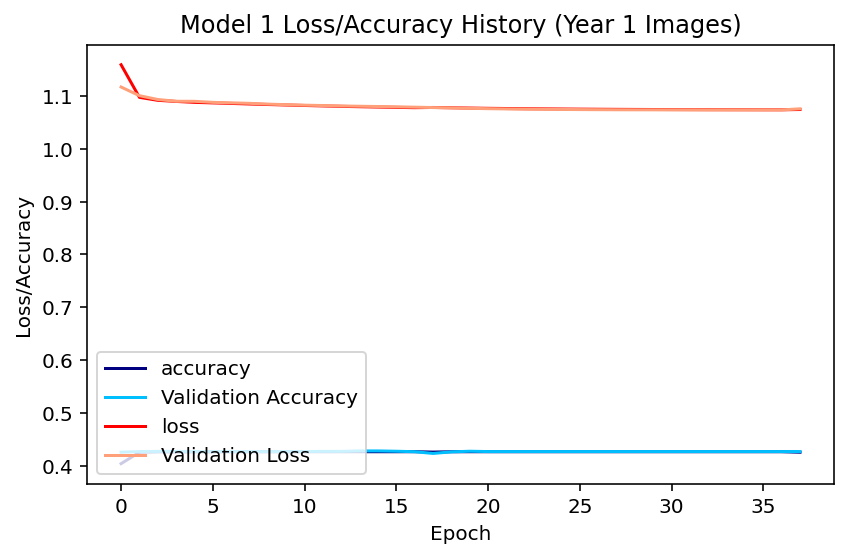

In [102]:
# Accuracy
acc = n['accuracy']
val_acc = n['val_accuracy']

# Loss
loss = n['loss']
val_loss = n['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 1 Loss/Accuracy History (Year 1 Images)")
plt.tight_layout()
axis1.legend(loc='lower left')

In [232]:
y_pred = loaded_model.predict(X_test_1)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

210/210 [==============================] - 2s 9ms/step


Text(0.5, 15.0, 'Predicted label')

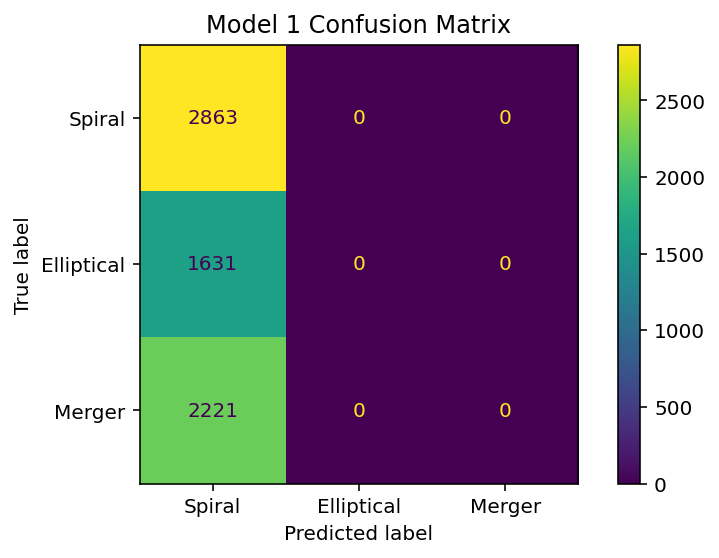

In [236]:
cm = confusion_matrix(y_test, y_pred)
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot()
plt.title('Model 1 Confusion Matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label') 

In [234]:
# Classification report
classification_metrics = classification_report(y_test, y_pred, target_names=class_names)
pprint(classification_metrics)

('              precision    recall  f1-score   support\n'
 '\n'
 '      Spiral       0.43      1.00      0.60      2863\n'
 '  Elliptical       0.00      0.00      0.00      1631\n'
 '      Merger       0.00      0.00      0.00      2221\n'
 '\n'
 '    accuracy                           0.43      6715\n'
 '   macro avg       0.14      0.33      0.20      6715\n'
 'weighted avg       0.18      0.43      0.25      6715\n')


In [235]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.426359


### Model 2

Changes:

Added image augmentation

Increased dropout rates to 0.8 after first dropout layer

Increased the number of layers and filter size

Added padding to Maxpool

Added callback to change Learning Rate at plateau, monitoring validation loss

In [238]:
input_shape = (3, 100, 100)

# Constraints for block 1
inputs = Input(shape=input_shape)
x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first', name='conv_1')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_1')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 2
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_3')(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_4')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_2')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 3
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_5')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_6')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_7')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_3')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 4
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_8')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_9')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_10')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_4')(x)
x = Dropout(rate=0.8)(x)

# Constraints for block 5
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_11')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_12')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_13')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_5')(x)
x = Dropout(rate=0.8)(x)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(x)

# hidden layers
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(x)
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(x)
x = Dense(1000, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model2 = Model(inputs=inputs, outputs=outputs, name='Model-2')

# Compile model
model2.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model2.summary()


Model: "Model-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 100, 100)      4864      
                                                                 
 conv_2 (Conv2D)             (None, 64, 100, 100)      36928     
                                                                 
 batch_normalization_24 (Bat  (None, 64, 100, 100)     400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 64, 50, 50)        0         
                                                                 
 dropout_24 (Dropout)        (None, 64, 50, 50)        0         
                                                           

In [239]:
image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.2,               
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      vertical_flip = True,
      horizontal_flip=True)

In [240]:
image_gen_train = image_gen.flow(X_train_1, Y_train)

image_gen_valid = image_gen.flow(X_valid_1, Y_valid)

In [241]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
      BackupAndRestore(backup_dir='backups'),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True),
     History()]


In [242]:
batch_size = 128
NUM_EPOCH = 100

In [247]:
history2 = model2.fit(image_gen_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data= image_gen_valid,
                    shuffle = shuffle,
                    verbose = 1,
                    initial_epoch=8,
                    callbacks = es
            )

Epoch 9/100
734/734 [==============================] - ETA: 0s - loss: 1.0749 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 783s 1s/step - loss: 1.0749 - accuracy: 0.4265 - val_loss: 1.0740 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 10/100
734/734 [==============================] - ETA: 0s - loss: 1.0738 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 786s 1s/step - loss: 1.0738 - accuracy: 0.4265 - val_loss: 1.0734 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 11/100
734/734 [==============================] - ETA: 0s - loss: 1.0734 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 782s 1s/step - loss: 1.0734 - accuracy: 0.4265 - val_loss: 1.0731 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 12/100
734/734 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 780s 1s/step - loss: 1.0732 - accuracy: 0.4265 - val_loss: 1.0731 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 13/100
734/734 [==============================] - ETA: 0s - loss: 1.0733 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 780s 1s/step - loss: 1.0733 - accuracy: 0.4265 - val_loss: 1.0731 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 14/100
734/734 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 779s 1s/step - loss: 1.0732 - accuracy: 0.4265 - val_loss: 1.0731 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 15/100
734/734 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 780s 1s/step - loss: 1.0732 - accuracy: 0.4265 - val_loss: 1.0730 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 16/100
734/734 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 778s 1s/step - loss: 1.0732 - accuracy: 0.4265 - val_loss: 1.0730 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 17/100
734/734 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 779s 1s/step - loss: 1.0732 - accuracy: 0.4265 - val_loss: 1.0730 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 18/100
734/734 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 779s 1s/step - loss: 1.0732 - accuracy: 0.4265 - val_loss: 1.0730 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 19/100
734/734 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 780s 1s/step - loss: 1.0732 - accuracy: 0.4265 - val_loss: 1.0730 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 20/100
734/734 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.4265WARNING:tensorflow:Can save best model only with val_acc available, skipping.


734/734 [==============================] - 779s 1s/step - loss: 1.0732 - accuracy: 0.4265 - val_loss: 1.0731 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 20: early stopping


In [248]:
# save whole model
model2.save('Model-2')

INFO:tensorflow:Assets written to: Model-2/assets


INFO:tensorflow:Assets written to: Model-2/assets


In [250]:
# Evaluate the model on test data
test_score = model2.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (model2.metrics_names[1], test_score[1]*100))

210/210 [==============================] - 35s 163ms/step - loss: 1.0732 - accuracy: 0.4264
accuracy: 42.64%


In [251]:
# Evaluate the model on test smaller subset
test_sub_score = model2.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (model2.metrics_names[1], test_sub_score[1]*100))

5/5 [==============================] - 1s 161ms/step - loss: 1.1225 - accuracy: 0.3333
accuracy: 33.33%


In [252]:
# Save data
model2.save_weights('weights.h5', overwrite=True)
open('model2.json', 'w').write(model2.to_json())

16451

In [258]:
#Saving history for future use
with open('model2/history.json', 'w') as f:
    json.dump(str(history2.history), f)

#### Visualizing training results

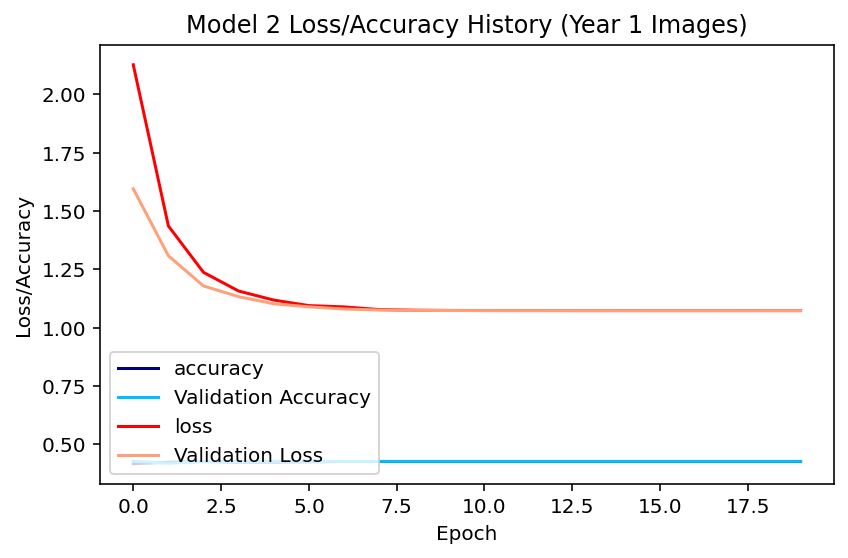

In [259]:
# Accuracy
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

# Loss
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 2 Loss/Accuracy History (Year 1 Images)")
plt.tight_layout()
axis1.legend(loc='lower left')

In [260]:
y_pred = model2.predict(X_test_1)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

  1/210 [..............................] - ETA: 46s

2022-06-13 22:55:01.048247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 33s 155ms/step


Text(0.5, 15.0, 'Predicted label')

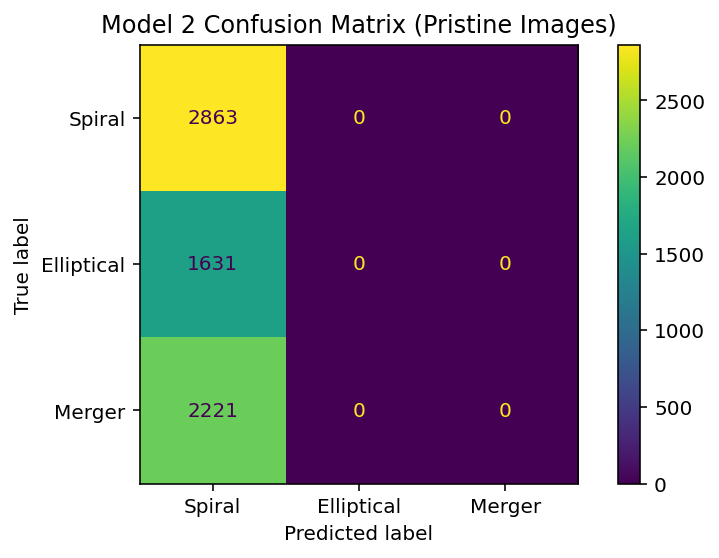

In [261]:
cm = confusion_matrix(y_test, y_pred)
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot()
plt.title('Model 2 Confusion Matrix (Pristine Images)')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label') 

In [262]:
# Classification report
classification_metrics = classification_report(y_test, y_pred, target_names=class_names)
pprint(classification_metrics)

('              precision    recall  f1-score   support\n'
 '\n'
 '      Spiral       0.43      1.00      0.60      2863\n'
 '  Elliptical       0.00      0.00      0.00      1631\n'
 '      Merger       0.00      0.00      0.00      2221\n'
 '\n'
 '    accuracy                           0.43      6715\n'
 '   macro avg       0.14      0.33      0.20      6715\n'
 'weighted avg       0.18      0.43      0.25      6715\n')


In [263]:
# Accuracy, Precision, Recall scores
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.426359


### Model 3

changes:

edit dropout placement and size

decrease batch size

change ReduceLROnPlateau learning rate factor, monitor val_acc

edit image augmentation param ranges where available

In [11]:
input_shape = (3, 100, 100)

# Constraints for block 1
inputs = Input(shape=input_shape)
x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_first', name='conv_1')(inputs)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_1')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 2
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_3')(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_4')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_2')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 3
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_5')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_6')(x)
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_7')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_3')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 4
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_8')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_9')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_10')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_4')(x)
x = Dropout(rate=0.5)(x)

# Constraints for block 5
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_11')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_12')(x)
x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', data_format='channels_first', name='conv_13')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_5')(x)
x = Dropout(rate=0.5)(x)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(x)

# hidden layers
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(x)
x = Dropout(rate=0.5)(x)
x = Dense(4096, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(x)
x = Dropout(rate=0.5)(x)
x = Dense(1000, activation='relu', kernel_regularizer=l2(0.0001), name='dense_3')(x)
x = Dropout(rate=0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model3 = Model(inputs=inputs, outputs=outputs, name="Model-3")

# Compile model
model3.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model3.summary()

2022-06-21 10:48:36.056505: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-21 10:48:36.056967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "Model-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 100, 100)      4864      
                                                                 
 conv_2 (Conv2D)             (None, 64, 100, 100)      36928     
                                                                 
 batch_normalization (BatchN  (None, 64, 100, 100)     400       
 ormalization)                                                   
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 64, 50, 50)        0         
                                                                 
 dropout (Dropout)           (None, 64, 50, 50)        0         
                             

In [12]:
image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.6,               
      height_shift_range=0.6,
      shear_range=0.6,
      zoom_range=0.6,
      vertical_flip = True,
      horizontal_flip=True)

In [13]:
image_gen_train = image_gen.flow(X_train_1, Y_train)

image_gen_valid = image_gen.flow(X_valid_1, Y_valid)

In [17]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=0.001, patience=5),
      BackupAndRestore(backup_dir='backups'),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='best_weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True),
     History()]

In [18]:
batch_size = 128
NUM_EPOCH = 100

In [ ]:
# Train model 3 on batches with data augmentation
history3 = model3.fit(image_gen_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=image_gen_valid,
                    shuffle=shuffle,
                    verbose=1,
                    initial_epoch=32,
                    callbacks=es
            )

Epoch 17/100
734/734 [==============================] - ETA: 0s - loss: 1.0873 - accuracy: 0.4265

2022-06-21 11:03:17.368655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 17: val_accuracy improved from -inf to 0.42683, saving model to best_weights.h5
734/734 [==============================] - 816s 1s/step - loss: 1.0873 - accuracy: 0.4265 - val_loss: 1.0872 - val_accuracy: 0.4268 - lr: 1.0000e-09
Epoch 18/100
734/734 [==============================] - ETA: 0s - loss: 1.0873 - accuracy: 0.4265
Epoch 18: val_accuracy did not improve from 0.42683
734/734 [==============================] - 837s 1s/step - loss: 1.0873 - accuracy: 0.4265 - val_loss: 1.0872 - val_accuracy: 0.4268 - lr: 1.0000e-09
Epoch 19/100
734/734 [==============================] - ETA: 0s - loss: 1.0875 - accuracy: 0.4265
Epoch 19: val_accuracy did not improve from 0.42683
734/734 [==============================] - 828s 1s/step - loss: 1.0875 - accuracy: 0.4265 - val_loss: 1.0872 - val_accuracy: 0.4268 - lr: 1.0000e-09
Epoch 20/100
734/734 [==============================] - ETA: 0s - loss: 1.0874 - accuracy: 0.4265
Epoch 20: val_accuracy did not improve from 0.42683
734/734 [=======

In [ ]:
model3.save('Model-3')

In [ ]:
# Save data
model3.save_weights('weights.h5', overwrite=True)
open('model3.json', 'w').write(model3.to_json())

#Saving history for future use
with open('model3/history.json', 'w') as f:
    json.dump(history3.history, f)

#### Visualizing training results

In [55]:
# Accuracy
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

# Loss
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 3 Loss/Accuracy History (Year 1 Images)")
plt.tight_layout()
axis1.legend(loc='lower left')

NameError: name 'history3' is not defined

In [56]:
y_pred = model2.predict(X_test_1)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

2022-05-31 23:13:49.017123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 72/210 [=========>....................] - ETA: 21s

KeyboardInterrupt: 

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot()
plt.title('Model 2 Confusion Matrix (Pristine Images)')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label') 

In [ ]:
# Classification report
classification_metrics = classification_report(y_test, y_pred, target_names=class_names)
pprint(classification_metrics)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy: %f' % accuracy)

# Train On Year 10 (pristine images)

### Model 5

In [73]:
input_shape = (3, 100, 100)

# Constraints for layer 1
# input: tensors of shape (color_channels, image_height, image_width), ignoring batch size
x = Input(shape=input_shape)
#For CNN: Convolution typically uses 3x3 windows, stride 1 & with padding. Will try 5x5 window first to attempt tp catch more features, but try multiple
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
# normalize input for first layer & also apply to each of the hidden layers
b0 = BatchNormalization()(c0)
#For CNN: pooling typically uses 2x2 windows, stride 2 & no padding
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.5)(d2)

#flatten (or unroll) the 3D output to 1D
f = Flatten()(e2)

# hidden layer
# Dense layer: takes 1D vector as input, current output is a 3D tensor; start simple, then change unit to try to increase performance
# use L2 regulization: take sum of all params squared & add it w/ square difference of actual output & predictions
# weights not sparse, will get much better accuracy than L1
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
# output layer must create 3 output values, one for each class
# use “softmax” activation function to ensure output values are in range 0-1 & may be used as predicted probabilities
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model5 = Model(inputs=x, outputs=y, name="Model-5")

# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
loss = 'categorical_crossentropy' 

model5.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model5.summary()

Model: "Model-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_14 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_14 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                           

In [74]:
image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.8,               
      height_shift_range=0.8,
      shear_range=0.8,
      zoom_range=0.8,
      vertical_flip = True,
      horizontal_flip=True)

In [75]:
image_gen_train_Y10 = image_gen.flow(X_train_10, Y_train)
image_gen_valid_Y10 = image_gen.flow(X_valid_10, Y_valid)

In [76]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=0.001, mode="auto", patience=5),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='Y10_best_weights.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True),
     History()]


In [77]:
batch_size = 128
NUM_EPOCH = 100

In [78]:
history5 = model5.fit(image_gen_train_Y10,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data= image_gen_valid_Y10,
                    shuffle = shuffle,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/100


2022-06-21 16:27:07.941220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - ETA: 0s - loss: 1.1379 - accuracy: 0.4049

2022-06-21 16:28:17.913727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 77s 104ms/step - loss: 1.1379 - accuracy: 0.4049 - val_loss: 1.1384 - val_accuracy: 0.3729 - lr: 0.0010
Epoch 2/100
734/734 [==============================] - 77s 105ms/step - loss: 1.0940 - accuracy: 0.4227 - val_loss: 1.0934 - val_accuracy: 0.4134 - lr: 0.0010
Epoch 3/100
734/734 [==============================] - 78s 106ms/step - loss: 1.0903 - accuracy: 0.4225 - val_loss: 1.0878 - val_accuracy: 0.4238 - lr: 0.0010
Epoch 4/100
734/734 [==============================] - 77s 104ms/step - loss: 1.0853 - accuracy: 0.4249 - val_loss: 1.0828 - val_accuracy: 0.4247 - lr: 0.0010
Epoch 5/100
734/734 [==============================] - 78s 106ms/step - loss: 1.0821 - accuracy: 0.4251 - val_loss: 1.0806 - val_accuracy: 0.4262 - lr: 0.0010
Epoch 6/100
734/734 [==============================] - 76s 103ms/step - loss: 1.0805 - accuracy: 0.4262 - val_loss: 1.0783 - val_accuracy: 0.4271 - lr: 0.0010
Epoch 7/100
734/734 [==============================] - 76s

In [79]:
model5.save('Model-5')

INFO:tensorflow:Assets written to: Model-5/assets


INFO:tensorflow:Assets written to: Model-5/assets


In [80]:
# Evaluate the model on test data
score = model5.evaluate(X_test_10, Y_test, verbose=True)
print("%s: %.2f%%" % (model5.metrics_names[1], score[1]*100))

210/210 [==============================] - 3s 12ms/step - loss: 1.0732 - accuracy: 0.4264
accuracy: 42.64%


In [81]:
# Evaluate the model on test smaller subset
score = model5.evaluate(X_test_10_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (model5.metrics_names[1], score[1]*100))

5/5 [==============================] - 0s 21ms/step - loss: 1.1244 - accuracy: 0.3333
accuracy: 33.33%


In [84]:
# Save data
model5.save_weights('weights.h5', overwrite=True)
open('model5.json', 'w').write(model5.to_json())

#Saving history for future use
with open('model5/history.json', 'w') as f:
    json.dump(str(history5.history), f)

#### Visualizing training results

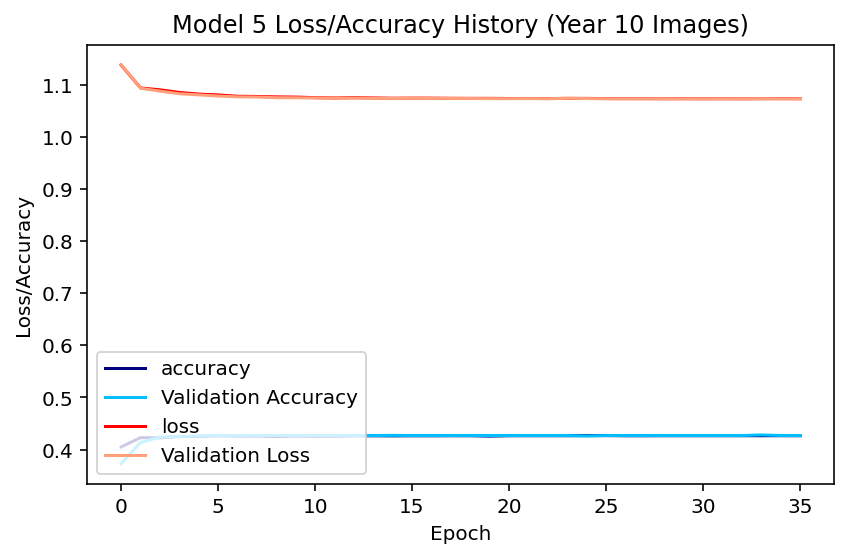

In [85]:
# Accuracy
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

# Loss
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 5 Loss/Accuracy History (Year 10 Images)")
plt.tight_layout()
axis1.legend(loc='lower left')

210/210 [==============================] - 2s 9ms/step
('              precision    recall  f1-score   support\n'
 '\n'
 '      Spiral       0.43      1.00      0.60      2863\n'
 '  Elliptical       0.00      0.00      0.00      1631\n'
 '      Merger       0.00      0.00      0.00      2221\n'
 '\n'
 '    accuracy                           0.43      6715\n'
 '   macro avg       0.14      0.33      0.20      6715\n'
 'weighted avg       0.18      0.43      0.25      6715\n')
'Accuracy: 0.426359'


Text(0.5, 15.0, 'Predicted label')

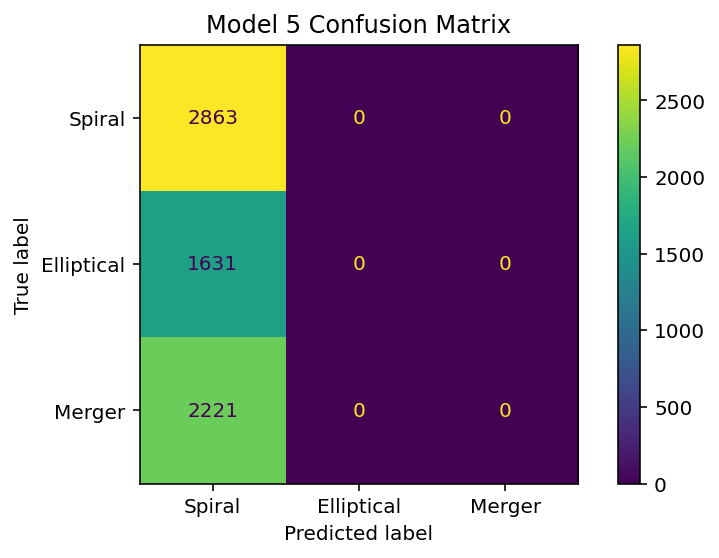

In [89]:
y_pred = model5.predict(X_test_10)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

# Classification report
classification_metrics = classification_report(y_test, y_pred, target_names=class_names)
pprint(classification_metrics)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
pprint('Accuracy: %f' % accuracy)

cm = confusion_matrix(y_test, y_pred)
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot()
plt.title('Model 5 Confusion Matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label') 

In [ ]:
def plot_grad_flow(named_parameters):
    avg_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            avg_grads.append(p.grad.abs().mean())
    plt.plot(avg_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(avg_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(avg_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(avg_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

In [ ]:
loss = self.criterion(outputs, labels)  
loss.backward()
plot_grad_flow(model.named_parameters())

In [ ]:
# layer = [layer for layer in model5.layers[1:]]

# with tf.GradientTape() as tape:
#     # Forward pass
#     y = layer(x)
#     loss = tf.reduce_mean(y**2)
    
# # Calculate gradients with respect to every trainable variable
# grad = tape.gradient(loss, layer.trainable_variables)

# for var, g in zip(layer.trainable_variables, grad):
#     print(f'{var.name}, shape: {g.shape}')


### Model 6

Potential Changes:

Dataset imbalance since there are more spirals than mergers and ellipticals -> try calculating class weights for weighted cross-entropy loss first 

In [120]:
# dataset is imbalanced
# generate class weights given a set of multi-class labels
def generate_class_weights(class_series):
    # class is one-hot encoded, so transform to categorical labels to use compute_class_weight   
    class_series = np.argmax(class_series, axis=1)
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    
    return dict(zip(class_labels, class_weights))

In [122]:
# calculate class weights to use
class_weights = generate_class_weights(Y_train)
print(class_weights)

{0: 0.7815713287411401, 1: 1.372304995617879, 2: 1.0082421120412106}


In [126]:
# Model 5 architecture
input_shape = (3, 100, 100)

# Constraints for layer 1
# input: tensors of shape (color_channels, image_height, image_width), ignoring batch size
x = Input(shape=input_shape)
#For CNN: Convolution typically uses 3x3 windows, stride 1 & with padding. Will try 5x5 window first to attempt tp catch more features, but try multiple
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
# normalize input for first layer & also apply to each of the hidden layers
b0 = BatchNormalization()(c0)
#For CNN: pooling typically uses 2x2 windows, stride 2 & no padding
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.5)(d2)

#flatten (or unroll) the 3D output to 1D
f = Flatten()(e2)

# hidden layer
# Dense layer: takes 1D vector as input, current output is a 3D tensor; start simple, then change unit to try to increase performance
# use L2 regulization: take sum of all params squared & add it w/ square difference of actual output & predictions
# weights not sparse, will get much better accuracy than L1
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
# output layer must create 3 output values, one for each class
# use “softmax” activation function to ensure output values are in range 0-1 & may be used as predicted probabilities
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model6 = Model(inputs=x, outputs=y, name="Model-6")

# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model6.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model6.summary()

Model: "Model-6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_7 (Batc  (None, 8, 100, 100)      400       
 hNormalization)                                                 
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                           

In [127]:
image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.8,               
      height_shift_range=0.8,
      shear_range=0.8,
      zoom_range=0.8,
      vertical_flip = True,
      horizontal_flip=True)

image_gen_train_Y10 = image_gen.flow(X_train_10, Y_train)
image_gen_valid_Y10 = image_gen.flow(X_valid_10, Y_valid)

In [128]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_lr=0.001, mode="auto", patience=5),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='Y10_best_weights.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True),
     History()
     ]

In [129]:
batch_size = 128
NUM_EPOCH = 100

In [131]:
history6 = model6.fit(image_gen_train_Y10,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data= image_gen_valid_Y10,
                    shuffle = shuffle,
                    class_weight=class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/100
734/734 [==============================] - 75s 103ms/step - loss: 1.1076 - accuracy: 0.3556 - val_loss: 1.2699 - val_accuracy: 0.3303 - lr: 0.0010
Epoch 2/100
734/734 [==============================] - 76s 103ms/step - loss: 1.1055 - accuracy: 0.2950 - val_loss: 1.1384 - val_accuracy: 0.3303 - lr: 0.0010
Epoch 3/100
734/734 [==============================] - 76s 103ms/step - loss: 1.1033 - accuracy: 0.3574 - val_loss: 1.1144 - val_accuracy: 0.3303 - lr: 0.0010
Epoch 4/100
734/734 [==============================] - 76s 103ms/step - loss: 1.1017 - accuracy: 0.3205 - val_loss: 1.1029 - val_accuracy: 0.3303 - lr: 0.0010
Epoch 5/100
734/734 [==============================] - 76s 104ms/step - loss: 1.1010 - accuracy: 0.3275 - val_loss: 1.1007 - val_accuracy: 0.3303 - lr: 0.0010
Epoch 6/100
734/734 [==============================] - 76s 103ms/step - loss: 1.1007 - accuracy: 0.3110 - val_loss: 1.1017 - val_accuracy: 0.3303 - lr: 0.0010
Epoch 7/100
734/734 [=========================

In [132]:
# Evaluate the model on test data
score = model6.evaluate(X_test_10, Y_test, verbose=True)
print("%s: %.2f%%" % (model6.metrics_names[1], score[1]*100))

210/210 [==============================] - 2s 11ms/step - loss: 1.0984 - accuracy: 0.4264
accuracy: 42.64%


In [133]:
# Evaluate the model on test smaller subset
score = model6.evaluate(X_test_10_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (model6.metrics_names[1], score[1]*100))

5/5 [==============================] - 0s 23ms/step - loss: 1.0986 - accuracy: 0.3333
accuracy: 33.33%


#### Visualizing training results

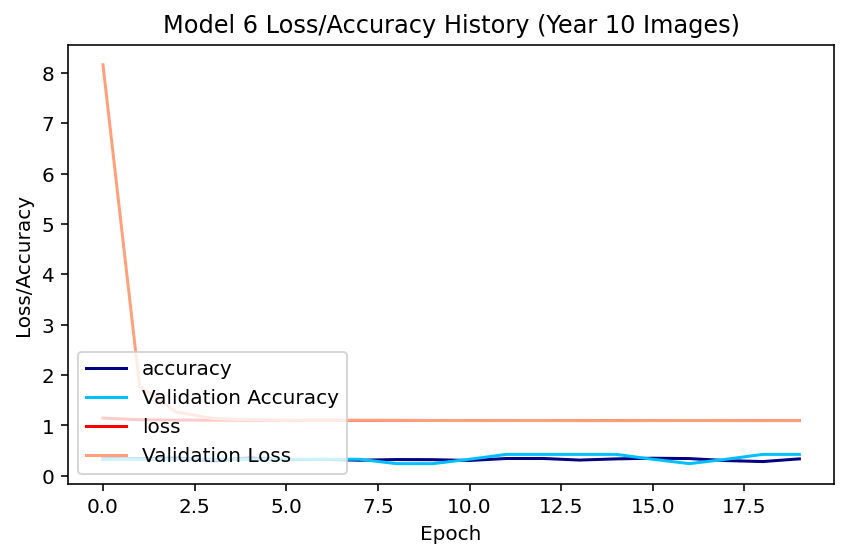

In [135]:
# Accuracy
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

# Loss
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Model 6 Loss/Accuracy History (Year 10 Images)")
plt.tight_layout()
axis1.legend(loc='lower left')

  2/210 [..............................] - ETA: 15s

2022-06-29 13:34:25.413079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 2s 9ms/step
('              precision    recall  f1-score   support\n'
 '\n'
 '      Spiral       0.43      1.00      0.60      2863\n'
 '  Elliptical       0.00      0.00      0.00      1631\n'
 '      Merger       0.00      0.00      0.00      2221\n'
 '\n'
 '    accuracy                           0.43      6715\n'
 '   macro avg       0.14      0.33      0.20      6715\n'
 'weighted avg       0.18      0.43      0.25      6715\n')
'Accuracy: 0.426359'


Text(0.5, 15.0, 'Predicted label')

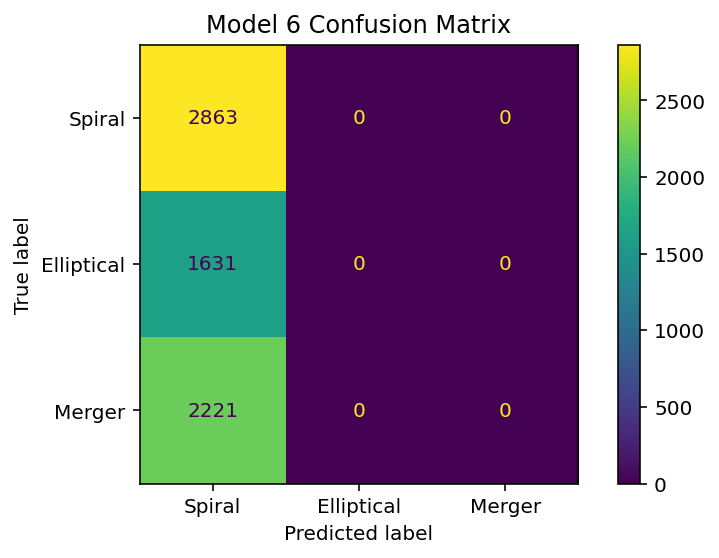

In [136]:
y_pred = model6.predict(X_test_10)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(Y_test, axis=1)

# Classification report
classification_metrics = classification_report(y_test, y_pred, target_names=class_names)
pprint(classification_metrics)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
pprint('Accuracy: %f' % accuracy)

cm = confusion_matrix(y_test, y_pred)
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot()
plt.title('Model 6 Confusion Matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label') 

### Model 7

In [26]:
input_shape = (3, 100, 100)

inputs = Input(shape=input_shape)
x = Dropout(rate=0.8)(x)
#block1
# Zero-Padding
x = ZeroPadding2D((3, 3))(inputs)
x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), data_format='channels_first', name='conv_1')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), data_format='channels_first', name='maxpool_1')(x)


#block2 - c
X = Conv2D(64, (1, 1), strides = (1,1))(x)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block3 - i
X = Conv2D(filters = 64, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

#block4 - i
X = Conv2D(filters = 64, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block5 - c
X = Conv2D(128, (1, 1), strides = (2,2))(x)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 6 - i
X = Conv2D(filters = 128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 7 - i
X = Conv2D(filters = 128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 8 - i
X = Conv2D(filters = 128, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 9 - c
X = Conv2D(256, (1, 1), strides = (2,2))(x)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 10 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 11 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 12 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 13 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 14 - i
X = Conv2D(filters = 256, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 1024, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 15 - c
X = Conv2D(512, (1, 1), strides = (2,2))(x)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Conv2D(filters = 2048, kernel_size = (1, 1), strides = (2,2), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 16 - i
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

# block 17 - i
X = Conv2D(filters = 512, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Conv2D(filters = 2048, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = AveragePooling2D((2,2), name="avg_pool")(X)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(X)

# hidden layers
outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model7 = Model(inputs=inputs, outputs=outputs, name="Model-7")

# Compile model
model7.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

model7.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 100, 100)      4864      
                                                                 
 conv_2 (Conv2D)             (None, 64, 100, 100)      36928     
                                                                 
 batch_normalization_10 (Bat  (None, 64, 100, 100)     400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 64, 50, 50)        0         
                                                                 
 dropout_10 (Dropout)        (None, 64, 50, 50)        0         
                                                           

In [28]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=5),
      BackupAndRestore(backup_dir='backups'),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='Y10_best_weights.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)]

In [29]:
batch_size = 64
NUM_EPOCH = 100

In [30]:
# Train model 3 on batches with data augmentation
history =  model7.fit(image_gen_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=image_gen_valid,
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 1/100


2022-05-31 18:32:51.616880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 64/734 [=>............................] - ETA: 11:46 - loss: 3.2296 - accuracy: 0.3789

KeyboardInterrupt: 

In [22]:
model4.save('model4')

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


# Save Final Best Model

In [37]:
#loading best performing model history
path = 'model/history.json'
if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
             n = json.loads(f.read())
                
# loading best performing model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load best weights into new model
loaded_model.load_weights('best_weights.h5')
print("Loaded model from disk")

# Visualizing Feature/Activation Maps

#### Visualize for Final Model

In [38]:
# Extracts the outputs of all layers except the input layer
layer_outputs = [layer.output for layer in loaded_model.layers[1:]]

# Creates model that will return these outputs, given the model input
activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs) 

# returns the values of the layer activations in model
# Returns a list of Numpy arrays: one array per layer activation
activations = activation_model.predict(X_test_10) 

  6/210 [..............................] - ETA: 5s

2022-06-03 22:01:23.049238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 4s 18ms/step


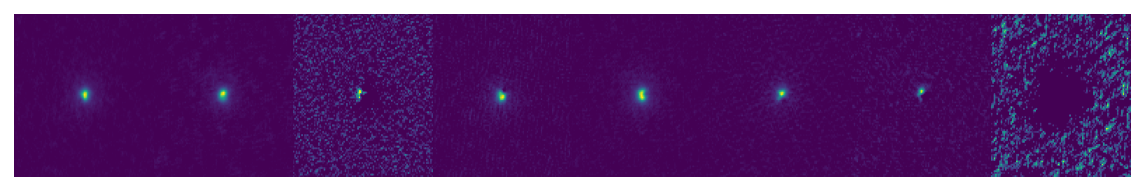

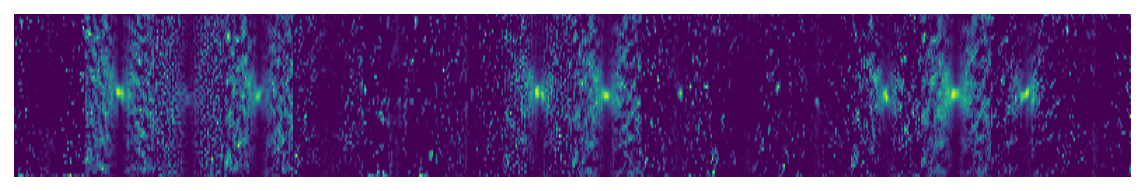

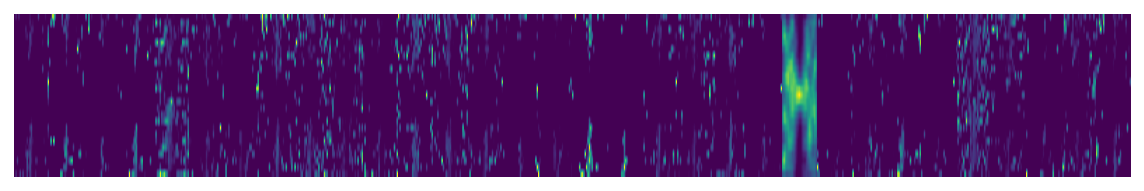

In [39]:
# activation maps for all filters in each convolutional layer
fig1=plt.figure(figsize=(11,1.5))  
for i in range(8):
    plt.subplot(1, 8, i + 1)
    layer_activation = activations[0]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)

fig2=plt.figure(figsize=(11,3))  
for i in range(16):
    plt.subplot(2, 16, i + 1)
    layer_activation = activations[4]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    
fig3=plt.figure(figsize=(15,6))  
for i in range(32):
    plt.subplot(4, 32, i + 1)
    layer_activation = activations[8]
    plt.imshow(layer_activation[1649, i, :, :], cmap='viridis', aspect='auto')
    plt.axis("off")
    plt.subplots_adjust(hspace=0, wspace=0)
    

In [42]:
# seraching for examples
prob = model1.predict(X_test_10)
pred =  (prob > 0.5).astype('int32') 

for i in range(len(Y_test)):
    if (Y_test[i] == 1 and pred[i,0] == 1): # and other y_test vs pered combinations TP=(1,1), FP=(0,1), TN=(0,0), FN=(1,0)
        print (i)
        print(Y_test[i],pred[i])

210/210 [==============================] - 2s 9ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Fine Tuning - Transfer Learning

Trying to transfer ability to extract features over to new dataset. Initialize network w/ the weights from saved model, freeze all Conv2D & Max-pooling layers so weights not modified.

-We expect this performance to likely be worse since images are noisier.

-All images in both source and target domain are labeled: Inductive transfer learning 

-Using saved model as a fixed feature extractor for noisy data.


In [88]:
# remove fully connected layers of model and add to classifier 
# to fine-tune; make last layer the output

#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
inputs = Input(shape=input_shape)
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(inputs)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b2)
outputs = Dropout(0.5)(d2)

base_model = Model(inputs=inputs, outputs=outputs)

base_model.trainable = False
    
base_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv2d (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_12 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 50, 50)        0         
 )                                                               
                                                                 
 dropout_12 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 50, 50)        1168

In [93]:
input_shape = (3, 100, 100)
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
#flatten (or unroll) the 3D output to 1D
f = Flatten()(x)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001))(z0)
outputs = Dense(NUM_CLASSES, activation='softmax')(z1)

TL_model = Model(inputs=inputs, outputs=outputs)

In [94]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
      BackupAndRestore(backup_dir='backups'),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='best_weights.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)]

In [95]:
# Compile Model
optimizer = 'adam'
metrics = ['accuracy']
# Multi-Class Cross-Entropy Loss
loss = 'categorical_crossentropy' 

TL_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

TL_model.summary() 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 model_3 (Functional)        (None, 32, 12, 12)        7116      
                                                                 
 flatten_9 (Flatten)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                294976    
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 304,271
Trainable params: 297,155
Non-trainab

In [96]:
# Train transfer learning model
batch_size = 128
NUM_EPOCH = 100

historyTL = TL_model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,
                    validation_data=(X_valid_1, Y_valid),
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 1/100


2022-06-03 22:44:56.532738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 181.4023 - accuracy: 0.3523

2022-06-03 22:45:03.470123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - 8s 41ms/step - loss: 181.4023 - accuracy: 0.3523 - val_loss: 38.5071 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 2/100
183/184 [============================>.] - ETA: 0s - loss: 84.4625 - accuracy: 0.3548WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 36ms/step - loss: 84.3864 - accuracy: 0.3547 - val_loss: 31.2569 - val_accuracy: 0.3168 - lr: 0.0010
Epoch 3/100
183/184 [============================>.] - ETA: 0s - loss: 60.4086 - accuracy: 0.3603WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 34ms/step - loss: 60.4191 - accuracy: 0.3602 - val_loss: 35.5226 - val_accuracy: 0.3967 - lr: 0.0010
Epoch 4/100
183/184 [============================>.] - ETA: 0s - loss: 37.6500 - accuracy: 0.3707WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 33ms/step - loss: 37.6182 - accuracy: 0.3706 - val_loss: 25.3239 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 5/100
184/184 [==============================] - ETA: 0s - loss: 23.0700 - accuracy: 0.3707WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 35ms/step - loss: 23.0700 - accuracy: 0.3707 - val_loss: 25.3026 - val_accuracy: 0.3404 - lr: 0.0010
Epoch 6/100
183/184 [============================>.] - ETA: 0s - loss: 17.5379 - accuracy: 0.3782WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 17.5342 - accuracy: 0.3780 - val_loss: 22.6165 - val_accuracy: 0.3389 - lr: 0.0010
Epoch 7/100
183/184 [============================>.] - ETA: 0s - loss: 19.3632 - accuracy: 0.3753WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 19.3362 - accuracy: 0.3753 - val_loss: 20.0432 - val_accuracy: 0.3586 - lr: 0.0010
Epoch 8/100
183/184 [============================>.] - ETA: 0s - loss: 10.6356 - accuracy: 0.3827WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 10.6252 - accuracy: 0.3829 - val_loss: 9.8152 - val_accuracy: 0.3508 - lr: 0.0010
Epoch 9/100
183/184 [============================>.] - ETA: 0s - loss: 9.0106 - accuracy: 0.3842WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 33ms/step - loss: 9.0056 - accuracy: 0.3843 - val_loss: 9.1560 - val_accuracy: 0.3070 - lr: 0.0010
Epoch 10/100
183/184 [============================>.] - ETA: 0s - loss: 6.6832 - accuracy: 0.3886WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 33ms/step - loss: 6.6820 - accuracy: 0.3884 - val_loss: 12.1274 - val_accuracy: 0.2745 - lr: 0.0010
Epoch 11/100
182/184 [============================>.] - ETA: 0s - loss: 4.8750 - accuracy: 0.3914WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 4.8544 - accuracy: 0.3912 - val_loss: 2.6634 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 12/100
182/184 [============================>.] - ETA: 0s - loss: 2.0181 - accuracy: 0.3766WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 32ms/step - loss: 2.0164 - accuracy: 0.3763 - val_loss: 1.8988 - val_accuracy: 0.3666 - lr: 0.0010
Epoch 13/100
183/184 [============================>.] - ETA: 0s - loss: 1.6282 - accuracy: 0.3753WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 34ms/step - loss: 1.6282 - accuracy: 0.3754 - val_loss: 1.6049 - val_accuracy: 0.3058 - lr: 0.0010
Epoch 14/100
183/184 [============================>.] - ETA: 0s - loss: 1.5182 - accuracy: 0.3751WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 39ms/step - loss: 1.5182 - accuracy: 0.3748 - val_loss: 1.4684 - val_accuracy: 0.3487 - lr: 0.0010
Epoch 15/100
183/184 [============================>.] - ETA: 0s - loss: 1.2804 - accuracy: 0.3833WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 37ms/step - loss: 1.2800 - accuracy: 0.3837 - val_loss: 1.2537 - val_accuracy: 0.4253 - lr: 0.0010
Epoch 16/100
184/184 [==============================] - ETA: 0s - loss: 1.1733 - accuracy: 0.4025WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 38ms/step - loss: 1.1733 - accuracy: 0.4025 - val_loss: 1.1304 - val_accuracy: 0.4030 - lr: 0.0010
Epoch 17/100
183/184 [============================>.] - ETA: 0s - loss: 1.1574 - accuracy: 0.4065WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 36ms/step - loss: 1.1571 - accuracy: 0.4068 - val_loss: 1.1189 - val_accuracy: 0.4012 - lr: 0.0010
Epoch 18/100
183/184 [============================>.] - ETA: 0s - loss: 1.1622 - accuracy: 0.4065WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 7s 39ms/step - loss: 1.1621 - accuracy: 0.4062 - val_loss: 1.1692 - val_accuracy: 0.3523 - lr: 0.0010
Epoch 19/100
183/184 [============================>.] - ETA: 0s - loss: 1.1337 - accuracy: 0.4092WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 35ms/step - loss: 1.1340 - accuracy: 0.4091 - val_loss: 1.2061 - val_accuracy: 0.4235 - lr: 0.0010
Epoch 20/100
184/184 [==============================] - ETA: 0s - loss: 1.1829 - accuracy: 0.4007WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 35ms/step - loss: 1.1829 - accuracy: 0.4007 - val_loss: 1.1248 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 21/100
183/184 [============================>.] - ETA: 0s - loss: 1.1406 - accuracy: 0.4134WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 34ms/step - loss: 1.1407 - accuracy: 0.4133 - val_loss: 1.1233 - val_accuracy: 0.3607 - lr: 0.0010
Epoch 22/100
183/184 [============================>.] - ETA: 0s - loss: 1.1669 - accuracy: 0.3997WARNING:tensorflow:Can save best model only with val_acc available, skipping.


184/184 [==============================] - 6s 34ms/step - loss: 1.1674 - accuracy: 0.3993 - val_loss: 1.2902 - val_accuracy: 0.3684 - lr: 0.0010
Epoch 22: early stopping


In [98]:
# Evaluate the model on noisy year 10 test data
score = TL_model.evaluate(X_test_10, Y_test, verbose=True)
print("%s: %.2f%%" % (TL_model.metrics_names[1], score[1]*100))


210/210 [==============================] - 3s 14ms/step - loss: 3.6009 - accuracy: 0.3574
accuracy: 35.74%


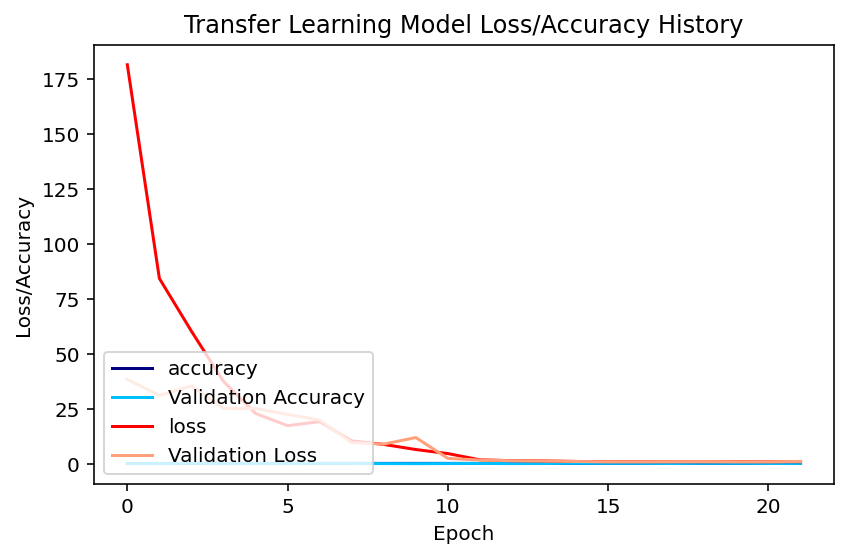

In [99]:
# Visualize training results
# Accuracy
acc = historyTL.history['accuracy']
val_acc = historyTL.history['val_accuracy']

# Loss
loss = historyTL.history['loss']
val_loss = historyTL.history['val_loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="Validation Accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="Validation Loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Transfer Learning Model Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower left')

In [100]:
TL_model.save("TL_model.h5")

### Use ResNet for Transfer Learning?

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


# Probabilistic CNN

Define prior and the posterior distributions of weights

Output a distribution instead of a deterministic tensor

In [105]:
# negative log-likelihood loss function
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [119]:
# define probabalistic model architecture

#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
inputs = Input(shape=input_shape)
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(inputs)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b2)
y = Dropout(0.5)(d2)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(y)
# hidden layers
x = Dense(tfp.layers.OneHotCategorical.params_size(3))(x)
outputs = tfp.layers.OneHotCategorical(3, convert_to_tensor_fn=tfp.distributions.Distribution.mode)(x)

probabilistic_model = Model(inputs=inputs, outputs=outputs)

In [120]:
# Compile model
probabilistic_model.compile( 
    optimizer='adam',
    loss=nll,
    metrics=['accuracy']
    )

probabilistic_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 3, 100, 100)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_18 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 50, 50)        0         
 2D)                                                             
                                                                 
 dropout_18 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 50, 50)        1168

In [121]:
# Train the probabalistic model
NUM_EPOCH = 100
batch_size = 128

In [143]:
# validation loss and accuracy not available
es = [EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5),
      ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5),
      BackupAndRestore(backup_dir='backups'),
# Save best weights in order to maximize validation accuracy, only saves when the model is considered the "best"
      ModelCheckpoint(filepath='best_weights.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)]

In [144]:
history_prob = probabilistic_model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,              
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 7/100
184/184 [==============================] - ETA: 0s - loss: 1.0975 - accuracy: 0.4162
Epoch 7: accuracy improved from -inf to 0.41619, saving model to best_weights.h5
184/184 [==============================] - 64s 348ms/step - loss: 1.0975 - accuracy: 0.4162 - lr: 0.0010
Epoch 8/100
184/184 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.4161
Epoch 8: accuracy did not improve from 0.41619
184/184 [==============================] - 64s 349ms/step - loss: 1.1004 - accuracy: 0.4161 - lr: 0.0010
Epoch 9/100
184/184 [==============================] - ETA: 0s - loss: 1.1025 - accuracy: 0.4140
Epoch 9: accuracy did not improve from 0.41619
184/184 [==============================] - 64s 348ms/step - loss: 1.1025 - accuracy: 0.4140 - lr: 0.0010
Epoch 10/100
184/184 [==============================] - ETA: 0s - loss: 1.1048 - accuracy: 0.4065
Epoch 10: accuracy did not improve from 0.41619
184/184 [==============================] - 64s 347ms/step - loss: 1.1048 

In [145]:
# Evaluate the model on test data
score = probabilistic_model.evaluate(X_test_1, Y_test, verbose=True)
print("%s: %.2f%%" % (probabilistic_model.metrics_names[1], score[1]*100))

# Evaluate the model on test smaller subset
score = probabilistic_model.evaluate(X_test_1_sub, Y_test_sub, verbose=True)
print("%s: %.2f%%" % (probabilistic_model.metrics_names[1], score[1]*100))


  1/210 [..............................] - ETA: 1:20 - loss: 1.1167 - accuracy: 0.3125

2022-06-04 00:46:02.942345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


210/210 [==============================] - 4s 16ms/step - loss: 1.0941 - accuracy: 0.4208
accuracy: 42.08%
5/5 [==============================] - 0s 28ms/step - loss: 1.1312 - accuracy: 0.3600
accuracy: 36.00%


In [146]:
probabilistic_model.save('probabilistic_model_M1.h5')

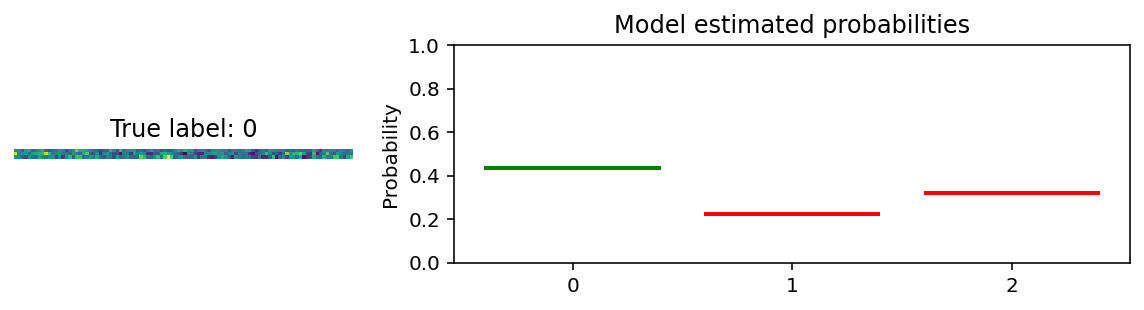

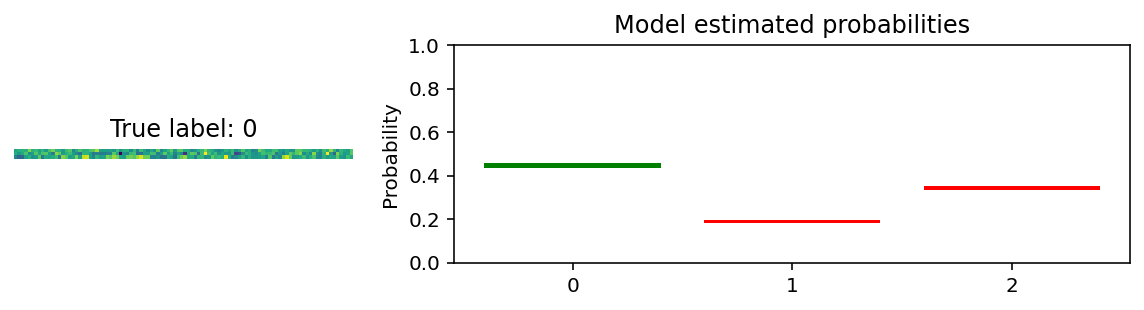

In [151]:
# look at probabilities of each class
# from https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/08/26/01-Bayesian-Convolutional-Neural-Network.html#Analyse-the-model-predictions
for i in [0,1577]:
    image = X_test_1[i]
    true_label = Y_test[i, 0]
    predicted_probabilities = np.empty(shape=(1, 3))
    
    for i in range(1):
        predicted_probabilities[i] = probabilistic_model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = probabilistic_model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0])
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    # make plots of probabilities that the model estimates
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(3)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(3)])    
    bar = ax2.bar(np.arange(3), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(3), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(3))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

In [172]:
# Visualize training results
# Accuracy
acc = history_prob.history['accuracy']

# Loss
loss = history_prob.history['loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')

plots = plot1_loss + plot1_lacc
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("BNN Model Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower left')

TypeError: 'History' object is not subscriptable

# Bayesian Neural Network

In [165]:
# define prior and posterior distributions
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [166]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train_1.shape[0]
kl_weight = 1 / X_train_1.shape[0]

In [169]:
# define bayesian model architecture

#(channels, rows, cols)
input_shape = (3, 100, 100)

# Constraints for layer 1
# For Reparameterization Layer
inputs = Input(shape=input_shape)
c0 = tfpl.Convolution2DReparameterization(
                filters=8, kernel_size=(5, 5),
                activation='relu', padding='same', data_format='channels_first',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
            )(inputs)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b0)
e0 = Dropout(0.5)(d0)

# Constraints for layer 2
c1 = tfpl.Convolution2DReparameterization(
                filters=16, kernel_size=(3, 3),
                activation='relu', padding='same', data_format='channels_first',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
            )(e0)

b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b1)
e1 = Dropout(0.5)(d1)

# Constraints for layer 3
c2 = tfpl.Convolution2DReparameterization(
                filters=32, kernel_size=(3, 3),
                activation='relu', padding='same', data_format='channels_first',
                kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                kernel_divergence_fn=divergence_fn,
                bias_prior_fn=tfpl.default_multivariate_normal_fn,
                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                bias_divergence_fn=divergence_fn
            )(e1)

b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first')(b2)
y = Dropout(0.5)(d2)

# flatten (or unroll) the 3D output to 1D
x = Flatten()(y)

# For Dense Variational Layer
x = tfp.layers.DenseVariational(
        units=3, make_posterior_fn=posterior, make_prior_fn=prior, kl_weight=kl_weight)(x)
outputs = tfp.layers.OneHotCategorical(3, convert_to_tensor_fn=tfp.distributions.Distribution.mode)(x)


In [170]:
bayesian_model = Model(inputs=inputs, outputs=outputs)

bayesian_model.compile( 
    optimizer='adam',
    loss=nll,
    metrics=['accuracy'],
    experimental_run_tf_function=False
    )

bayesian_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 3, 100, 100)]     0         
                                                                 
 conv2d_reparameterization_1  (None, 8, 100, 100)      1216      
 5 (Conv2DReparameterization                                     
 )                                                               
                                                                 
 batch_normalization_36 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 8, 50, 50)        0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 8, 50, 50)         0  

In [171]:
historyBNN = bayesian_model.fit(X_train_1, Y_train,
                    batch_size=batch_size,
                    epochs=NUM_EPOCH,              
                    shuffle=True,
                    verbose=1,
                    callbacks=es
            )

Epoch 1/100


2022-06-04 01:01:40.137560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 312.1453 - accuracy: 0.3368
Epoch 1: accuracy did not improve from 0.45838
184/184 [==============================] - 403s 2s/step - loss: 312.1453 - accuracy: 0.3368 - lr: 0.0010
Epoch 2/100
184/184 [==============================] - ETA: 0s - loss: 124.0086 - accuracy: 0.3435
Epoch 2: accuracy did not improve from 0.45838
184/184 [==============================] - 418s 2s/step - loss: 124.0086 - accuracy: 0.3435 - lr: 0.0010
Epoch 3/100
184/184 [==============================] - ETA: 0s - loss: 74.6073 - accuracy: 0.3400
Epoch 3: accuracy did not improve from 0.45838
184/184 [==============================] - 399s 2s/step - loss: 74.6073 - accuracy: 0.3400 - lr: 0.0010
Epoch 4/100
184/184 [==============================] - ETA: 0s - loss: 53.0653 - accuracy: 0.3525
Epoch 4: accuracy did not improve from 0.45838
184/184 [==============================] - 402s 2s/step - loss: 53.0653 - accuracy: 0.3525 - lr: 0.0010
Epoch 5/100


KeyboardInterrupt: 

In [173]:
# Evaluate the BNN model on test data
score = bayesian_model.evaluate(X_test_1, Y_test, verbose=False)
print("%s: %.2f%%" % (bayesian_model.metrics_names[1], score[1]*100))

# Evaluate the BNN model on test smaller subset
score = bayesian_model.evaluate(X_test_1_sub, Y_test_sub, verbose=False)
print("%s: %.2f%%" % (bayesian_model.metrics_names[1], score[1]*100))

2022-06-04 01:39:11.929874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


accuracy: 33.54%
accuracy: 35.33%


In [ ]:
for i in [0,1577]:
    image = X_test_1[i]
    true_label = Y_test[i, 0]
    predicted_probabilities = np.empty(shape=(200, 3))
    
    for i in range(200):
        predicted_probabilities[i] = bayesian_model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = bayesian_model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    # Show a 95% prediction interval of model predicted probabilities
    # make plots of probabilities that the model estimates
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(3)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(3)])    
    bar = ax2.bar(np.arange(3), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(3), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(3))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities')
    plt.show()

In [ ]:
# Visualize training results
# Accuracy
acc = historyBNN.history['accuracy']

# Loss
loss = historyBNN.history['loss']

epochs = list(range(len(loss)))

#plot
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')

plots = plot1_loss + plot1_lacc
labs = [l.get_label() for l in plots]

axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("BNN Model Loss/Accuracy History")
plt.tight_layout()
axis1.legend(loc='lower left')

In [ ]:
bayesian_model.save('bayesian_model_M1.h5')

In [ ]:
## plot entropy distribution later

## need to re-run fit for probabilistic and bnn w/ validation data, was somehow left out